In [1]:
print("Import Packages")

using FFTW
using LinearAlgebra
using JLD2
using YAML
using PyPlot
using PyCall

using CosmoMMF
# using Revise

plt.style.use("dark_mode")
mpl = pyimport("matplotlib")
@pyimport mpl_toolkits.axes_grid1 as axgrid

config = YAML.load_file("../config.yaml")

Import Packages

┌ Info: Precompiling CosmoMMF [70302bc8-d3c5-42b6-97d0-438349a59312]
└ @ Base loading.jl:1317


Dict{Any, Any} with 16 entries:
  "DM_particle_mass_Dark" => 0.00472716
  "run_name"              => "density_cube_snap_099_full_dm"
  "xmin"                  => 0.0
  "num_scales"            => 10
  "GAS_particle_mass_TNG" => 0.000743736
  "output_directory"      => "/global/cscratch1/sd/james12/NEXUS_analysis/"
  "nx"                    => 1024
  "N_GAS"                 => 15625000000
  "num_snaps"             => 1
  "snapfile_root"         => 99
  "algorithm"             => "NEXUS+"
  "input_directory"       => "/global/cscratch1/sd/james12/Illustris_TNG_Data/T…
  "simulation_type"       => "Dark"
  "DM_particle_mass_TNG"  => 0.00398343
  "N_DM"                  => 15625000000
  "xmax"                  => 205000.0

In [3]:
string(1.2)

"1.2"

In [2]:
CosmoMMF.test_print() #Nice, the CosmoMMF Package imported properly

This test function works! (totally)

In [3]:
config["input_directory"]

# "/global/cscratch1/sd/james12/NEXUS_analysis/density_cube_snap_099_full_dm.jld2"

"/global/cscratch1/sd/james12/Illustris_TNG_Data/TNG_Density_Cubes/"

In [4]:
load_string = config["input_directory"] * config["run_name"] * ".jld2"

@load load_string den

print("The size of the original density cube:")
print(size(den))

The size of the original density cube:(1024, 1024, 1024)

In [5]:
den_256_subset = den[1:256,1:256,1:256]
den_512_subset = den[1:512,1:512,1:512]

# den=nothing

print("We now want to test and see if hessian_fast and hessian_slow yield the same results on the subsets")

We now want to test and see if hessian_fast and hessian_slow yield the same results on the subsets

### 256^3 Hessian Calculation

In [6]:
n = 256
wave_vecs = CosmoMMF.wavevectors3D(Float64,(n,n,n))
density_field = den_256_subset .+ 0.0001 
print("Log Gauss Smoothing of 256: ")
@time smoothed_256_loggauss = CosmoMMF.smooth_loggauss(density_field, √2 , wave_vecs)
print("\n")
print("Gauss Smoothing of 256: ")
@time smoothed_256_gauss = CosmoMMF.smooth_gauss(density_field, √2 , wave_vecs)
print("\nFinished Smoothing")

Log Gauss Smoothing of 256:  10.592235 seconds (8.88 M allocations: 1.008 GiB)

Gauss Smoothing of 256:   6.191513 seconds (1.04 M allocations: 1.432 GiB, 2.76% gc time)
Finished Smoothing

In [8]:
print("Fast Hessian Computed: ")
@time Hessian_256_fast = CosmoMMF.fast_hessian_from_smoothed(smoothed_256_loggauss, √2 , wave_vecs)
print("\n")

print("Slow Hessian Computed: ")
@time Hessian_256_slow = CosmoMMF.slow_hessian_from_smoothed(smoothed_256_loggauss, √2 , wave_vecs)
print("\n")


print("Calculations Completed")


Fast Hessian Computed:  16.094114 seconds (1.11 M allocations: 5.810 GiB, 2.43% gc time, 3.67% compilation time)

Slow Hessian Computed:  16.887594 seconds (1.25 M allocations: 7.310 GiB, 3.21% gc time, 5.16% compilation time)

Calculations Completed

In [9]:
if Hessian_256_fast == Hessian_256_slow
    print("They are Equivalent")
else
    print("They are not Equivalent")
end


They are Equivalent

In [10]:
sum(Hessian_256_fast.^2 - Hessian_256_slow.^2)

0.0

### 512^3 Hessian Calculation

In [18]:
n = 512
wave_vecs = CosmoMMF.wavevectors3D(Float64,(n,n,n))
density_field = den_512_subset .+ 0.0001 
print("LogGauss Smoothing of 512: ")
@time smoothed_512_loggauss = CosmoMMF.smooth_loggauss(density_field, √2 , wave_vecs)
print("\n")
print("Gauss Smoothing of 512: ")
@time smoothed_512_gauss = CosmoMMF.smooth_gauss(density_field, √2 , wave_vecs)
print("\nFinished Smoothing")

# #we need to remove unnecessary wastes of ram
# den_512_subset = nothing
# den_256_subset = nothing
# density_field = nothing

print("Finished Smoothing")

LogGauss Smoothing of 512:  60.961236 seconds (260 allocations: 4.000 GiB, 1.75% gc time)

Gauss Smoothing of 512:  45.978253 seconds (100 allocations: 11.000 GiB, 2.21% gc time)

Finished SmoothingFinished Smoothing

In [13]:
print("Fast Hessian Computed: ")
@time Hessian_512_fast = CosmoMMF.fast_hessian_from_smoothed(smoothed_512, √2 , wave_vecs)
print("\n")

# Hessian_512_fast = nothing

print("Slow Hessian Computed: ")
@time Hessian_512_slow = CosmoMMF.slow_hessian_from_smoothed(smoothed_512, √2 , wave_vecs)
print("\n")

# Hessian_512_slow = nothing


print("Calculations Completed")


Fast Hessian Computed: 145.791967 seconds (485 allocations: 46.000 GiB, 0.97% gc time)

Slow Hessian Computed: 153.611878 seconds (348 allocations: 58.000 GiB, 1.82% gc time)

Calculations Completed

In [15]:
if Hessian_512_fast == Hessian_512_slow
    print("They are Equivalent")
else
    print("They are not Equivalent")
end

They are Equivalent

# Visualization of Smoothing

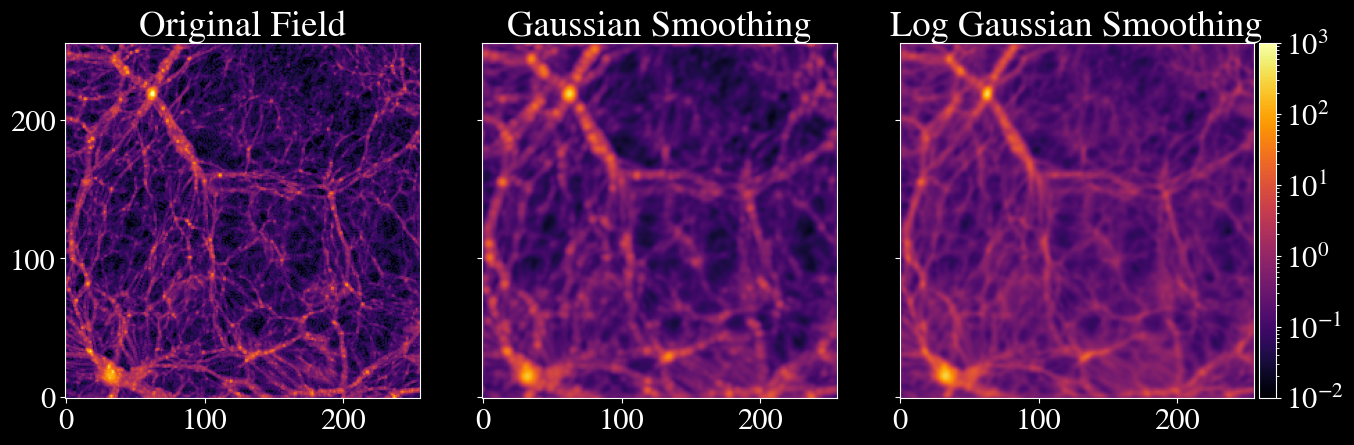

In [40]:
f, axes = plt.subplots(1,3,sharey=true, figsize=(14,6))
axes[1].set_title("Original Field")
im1 = axes[1].imshow(den_256_subset[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider1 = axgrid.make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax1.set_axis_off()

axes[2].set_title("Gaussian Smoothing")
im2 = axes[2].imshow(smoothed_256_gauss[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider2 = axgrid.make_axes_locatable(axes[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cax2.set_axis_off()

axes[3].set_title("Log Gaussian Smoothing")
im3 = axes[3].imshow(smoothed_256_loggauss[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider3 = axgrid.make_axes_locatable(axes[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im3, cax=cax3)
f.tight_layout()

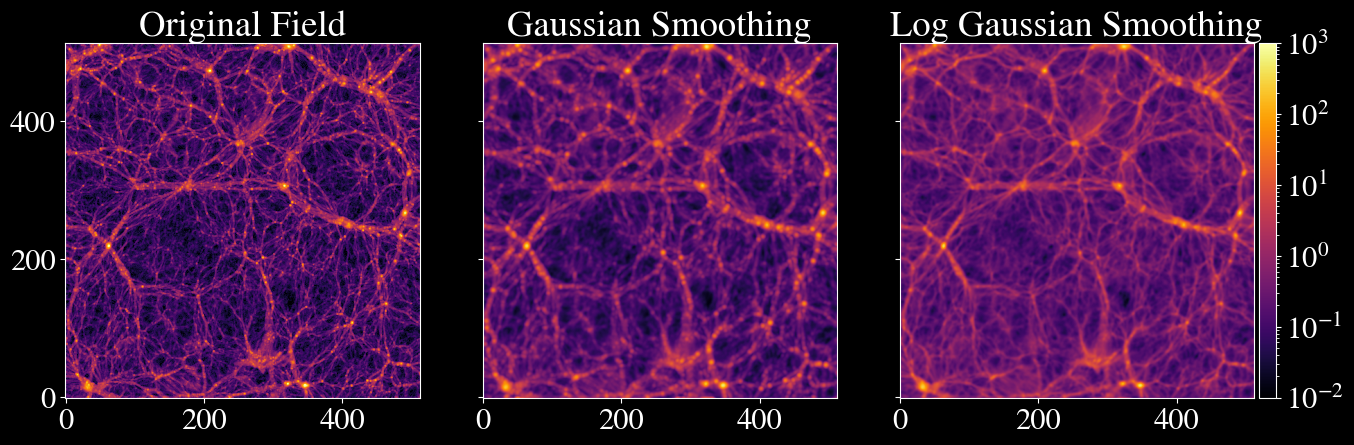

In [19]:
f, axes = plt.subplots(1,3,sharey=true, figsize=(14,6))
axes[1].set_title("Original Field")
im1 = axes[1].imshow(den_512_subset[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider1 = axgrid.make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax1.set_axis_off()

axes[2].set_title("Gaussian Smoothing")
im2 = axes[2].imshow(smoothed_512_gauss[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider2 = axgrid.make_axes_locatable(axes[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cax2.set_axis_off()

axes[3].set_title("Log Gaussian Smoothing")
im3 = axes[3].imshow(smoothed_512_loggauss[:,:,200], origin="lower", cmap="inferno", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))
divider3 = axgrid.make_axes_locatable(axes[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im3, cax=cax3)
f.tight_layout()

In [6]:
n = 256
wave_vecs = CosmoMMF.wavevectors3D(Float64,(n,n,n))
density_field = den_256_subset .+ 0.0001 
print("Log Gauss Smoothing of 256: ")
@time smoothed_256_loggauss = CosmoMMF.smooth_loggauss(density_field, √2 , wave_vecs)
# print("\n")
# print("Gauss Smoothing of 256: ")
# @time smoothed_256_gauss = CosmoMMF.smooth_gauss(density_field, √2 , wave_vecs)
print("\nFinished Smoothing")

Log Gauss Smoothing of 256:   9.646246 seconds (8.83 M allocations: 1.004 GiB)

Finished Smoothing

In [7]:
# print("Fast Hessian Computed: ")
# @time Hessian_256_fast = CosmoMMF.fast_hessian_from_smoothed(smoothed_256_loggauss, √2 , wave_vecs)
# print("\n")

print("Disk Hessian Computed: ")
@time CosmoMMF.reduce_RAM_hessian_from_smoothed(smoothed_256_loggauss, √2 , wave_vecs, config["output_directory"])
print("\n")

@time CosmoMMF.compile_sub_hessians(smoothed_256_loggauss, √2, "000", config["output_directory"])
print("\n")

print("Calculations Completed")

Disk Hessian Computed:  46.354302 seconds (106.94 M allocations: 8.374 GiB, 2.51% gc time)

  1.777797 seconds (2.64 M allocations: 533.825 MiB, 57.49% compilation time)

Calculations Completed

In [8]:
@time CosmoMMF.compile_sub_hessians(smoothed_256_loggauss, √2, "001", config["output_directory"])
print("\n")

  0.780491 seconds (1.11 k allocations: 384.087 MiB)



In [31]:
@load config["output_directory"] * "hessian_component_111_full.jld2" hessian_sub

1-element Vector{Symbol}:
 :hessian_sub

In [32]:
Hessian_256_fast[129:256,129:256,129:256,:] == real(hessian_sub)

true

In [9]:

Rs = (√2) .^ (0:2)
print("loading different scales")

@time combined_NEXUSPLUS = CosmoMMF.reduce_RAM_maximum_signature(Rs, config["output_directory"], den_256_subset; alg=:NEXUSPLUS);

loading different scales
Computing All Hessian Values: 

Compiling Hessians & Calculating Max Signatures: 
429.633769 seconds (909.58 M allocations: 59.391 GiB, 1.47% gc time)


In [19]:
@load config["output_directory"] * "max_sigs_001.jld2" sigmax_sub

1-element Vector{Symbol}:
 :sigmax_sub

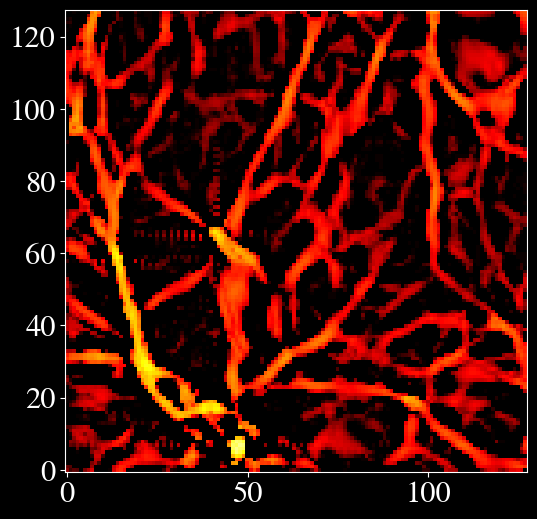

PyObject <matplotlib.image.AxesImage object at 0x2aab456463d0>

In [24]:
plt.imshow(sigmax_sub[:,:,64, 3], origin="lower", cmap="hot", norm=mpl.colors.LogNorm(vmin=0.01, vmax=1000.0))